# ACB - Music classification

## Import libraries

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import (
    VarianceThreshold, 
    SelectKBest,
    f_classif,
    mutual_info_classif
)

from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    matthews_corrcoef
)


from src.visualization.visualize import pairplot, class_distribution, interpret_steps
from src.models.minimum_distance import MinimumDistanceClassifier as MDC
from src.utils.dotenv_loading import ENV_CONFIG
from src.data.make_dataset import clean_dataset


%matplotlib inline

Show the versions of the modules used for the project:

In [3]:
print(f"{np.__name__} version = {np.__version__}")
print(f"{pd.__name__} version = {pd.__version__}")
print(f"{sklearn.__name__} version = {sklearn.__version__}")
print(f"{mpl.__name__} version = {mpl.__version__}")
print(f"{sns.__name__} version = {sns.__version__}")

numpy version = 1.24.2
pandas version = 1.5.3
sklearn version = 1.2.2
matplotlib version = 3.7.0
seaborn version = 0.12.2


In [4]:
SAVE = True

SEED = int(ENV_CONFIG["SEED"])
np.random.default_rng(seed=SEED)

Generator(PCG64) at 0x7FAD19A73040

## Reading the data and quick exploratory data analysis

In [5]:
df_raw = pd.read_csv(ENV_CONFIG["DATA_FOLDER"])
df_raw.shape

(999, 199)

In [6]:
df_raw.head()

,filename,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,label
0,blues.00000.wav,123.046875,0.350129,0.088772,1.0,0.001883,0.254469,0.112016,0.509971,0.130184,...,-7.189630,1.837867,1.222467,46.941350,32.866340,-23.219631,0.941804,-3.579244,5.497650,blues
1,blues.00001.wav,107.666016,0.340849,0.094976,1.0,0.001808,0.232328,0.089450,0.521089,0.095908,...,-4.961407,4.222943,0.530644,45.788700,27.740532,-17.131062,0.290101,-4.288013,4.693344,blues
2,blues.00002.wav,161.499023,0.363538,0.085257,1.0,0.003168,0.275098,0.130408,0.520045,0.175473,...,-8.082528,0.335357,-2.238128,30.653150,16.524359,-29.785423,-2.112655,-5.789953,1.266118,blues
3,blues.00003.wav,172.265625,0.404854,0.093999,1.0,0.005738,0.320005,0.145432,0.622788,0.141040,...,-4.728713,3.534681,-3.405046,31.965254,16.595015,-21.426252,-3.723261,-6.868982,-0.029808,blues
4,blues.00004.wav,135.999178,0.308526,0.087843,1.0,0.001347,0.201387,0.084953,0.429789,0.091501,...,-9.217802,0.448059,-11.704385,55.190254,4.889852,-41.730530,-10.748793,-15.777891,-6.449556,blues


In [7]:
df_raw.tail()

,filename,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,label
994,rock.00095.wav,103.359375,0.351977,0.080479,1.0,0.005424,0.263867,0.130719,0.486072,0.079446,...,-10.667875,-2.157617,-1.198403,49.946903,21.106043,-22.082030,-0.870149,-5.877096,3.354293,rock
995,rock.00096.wav,117.453835,0.398869,0.075117,1.0,0.015388,0.323889,0.184963,0.541574,0.076423,...,-11.642376,-3.169349,-2.791855,31.719294,14.861097,-19.902115,-3.008246,-6.528909,0.997393,rock
996,rock.00097.wav,129.199219,0.431980,0.075221,1.0,0.006835,0.370889,0.216633,0.591718,0.081598,...,-17.128510,-8.109871,-2.104325,29.860994,16.930466,-21.867311,-1.863467,-5.494790,1.414281,rock
997,rock.00098.wav,112.347147,0.362635,0.091532,1.0,0.000592,0.274618,0.110386,0.549156,0.083802,...,-9.732834,-0.612432,-3.587599,41.296356,20.287260,-22.774874,-3.836333,-7.861920,0.380314,rock
998,rock.00099.wav,123.046875,0.358318,0.085817,1.0,0.004010,0.262763,0.128006,0.515196,0.054431,...,-7.819255,3.772562,1.150108,49.735140,29.696540,-21.608265,0.684592,-3.657846,4.877181,rock


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 199 entries, filename to label
dtypes: float64(197), object(2)
memory usage: 1.5+ MB


In [9]:
df = clean_dataset(df_raw, "A")

In [10]:
df.head()

,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,rms_mean_var,...,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,genre
0,112.347145,0.303251,0.089593,1.0,0.001021,0.192122,0.072654,0.431641,0.026787,0.000342,...,-7.092338,4.157803,-3.818604,88.638634,37.769127,-29.682255,-5.023259,-9.993509,1.511925,others
1,161.499023,0.376988,0.083790,1.0,0.003654,0.283156,0.150821,0.535613,0.204271,0.001920,...,-5.752795,2.507965,-3.078908,51.755867,16.769207,-24.104900,-3.161209,-7.775723,1.794894,others
2,135.999176,0.401009,0.089657,1.0,0.002326,0.331715,0.145864,0.598354,0.182285,0.003976,...,-7.306152,1.171250,0.705028,55.644600,23.745577,-22.897854,0.639649,-4.493629,5.592843,blues
3,161.499023,0.325428,0.087600,1.0,0.001496,0.224143,0.095076,0.459756,0.071379,0.000794,...,-5.306351,4.497449,6.321081,100.530167,35.653419,-19.270657,6.225543,-0.877847,12.986521,others
4,112.347145,0.294611,0.088108,1.0,0.002020,0.185114,0.071379,0.403091,0.044323,0.001092,...,-9.735260,3.697661,-3.284700,97.682816,31.533157,-24.643005,-4.996558,-10.412316,1.571471,others


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 198 entries, tempo to genre
dtypes: category(1), float32(197)
memory usage: 770.0 KB


In [12]:
print(f"Number of missing values in the dataset is {df.isnull().sum().sum()}")

Number of missing values in the dataset is 0


Since the number of missing values is zero, there's no need to check each column to see how they're distributed

## Quick plot to check to see each variable distribuition and the correlation between each other

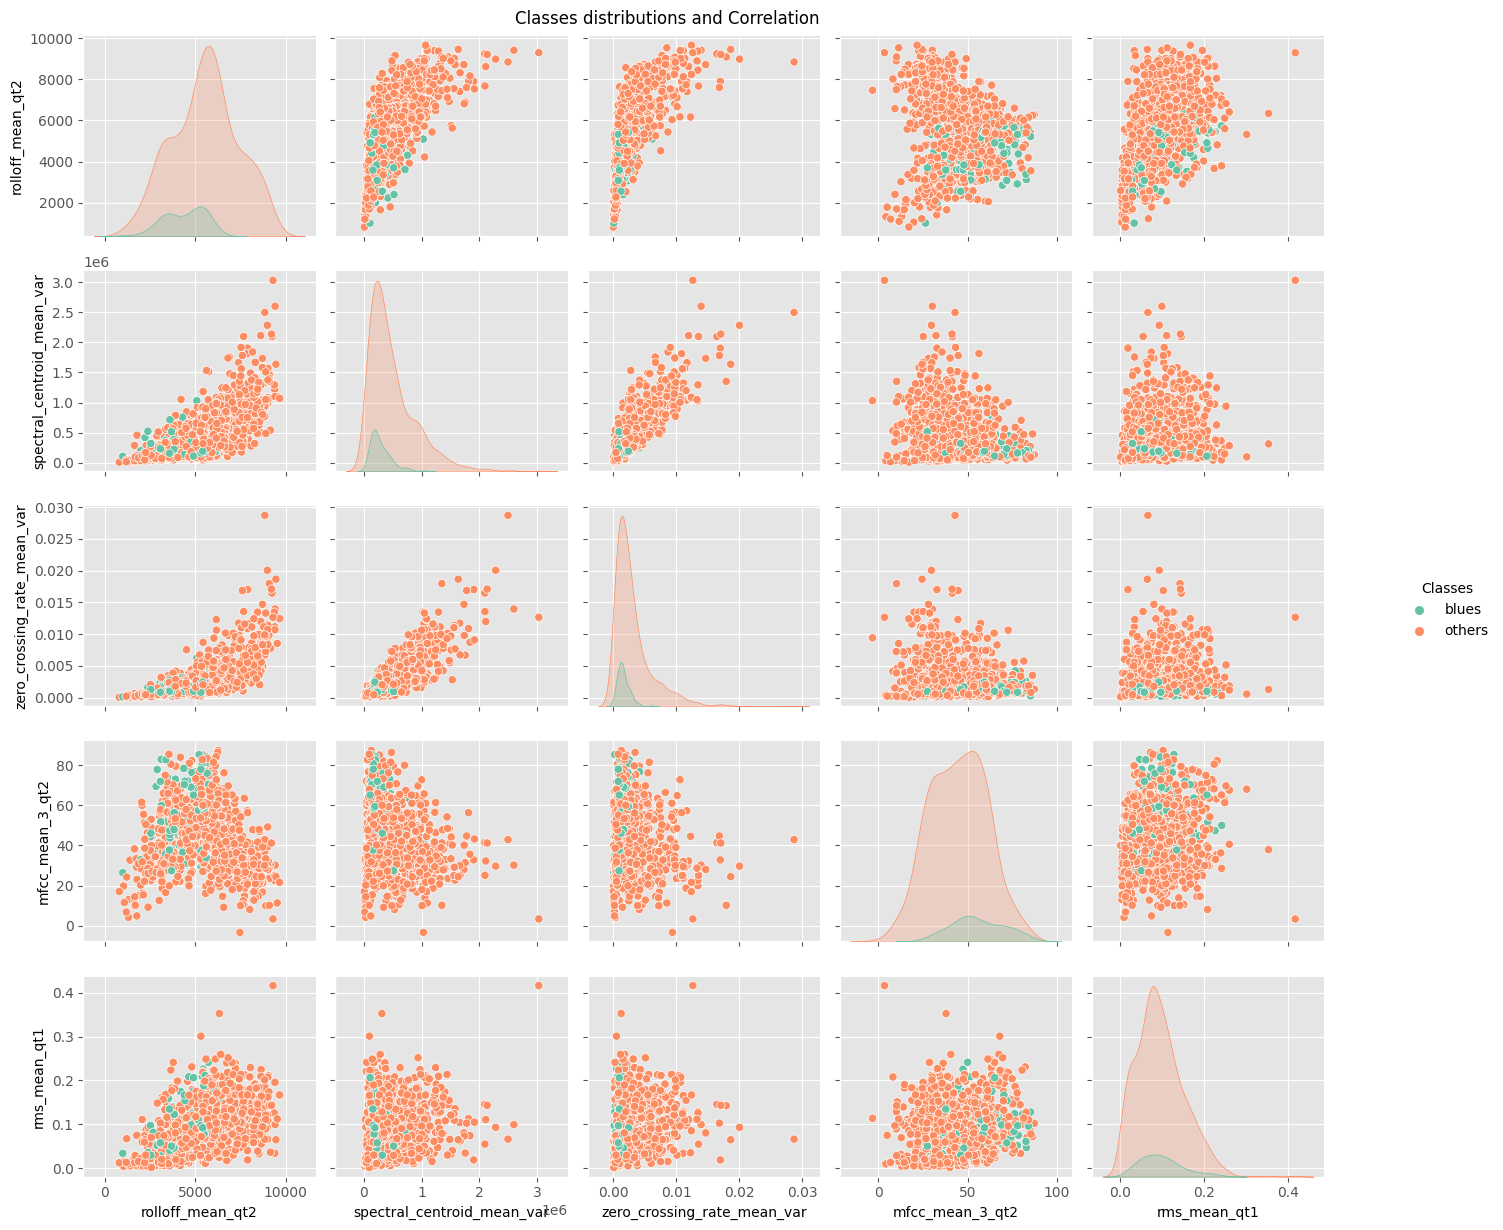

In [13]:
pairplot(
    data = df,
    target_variable = "genre",
    save_image=SAVE
)

## See the distribution of the target variable, the music genre

For scenario A:
one against all so well pick a genre a treat it like the target variable of interest and the rest as other

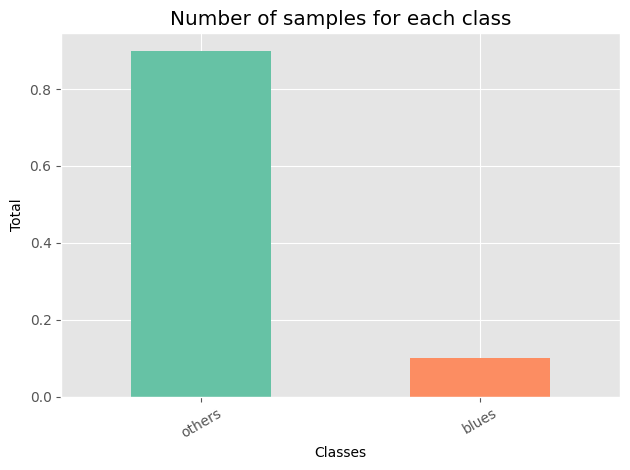

In [14]:
class_distribution(
    df,
    target_variable = "genre",
    save_image = SAVE
)

With our data cleaned up and with some quick vizualization of our variables we can proceed to the next step.

## Feature selection/Feature reduction

Here we split the dataframe into our features and the target variables.
We also extract the features names with the goal to be able the interpret the feature selection algorithms results.

In [15]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

input_features = df.columns[:-1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = SEED, test_size = .2)

In [17]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Removing Outliers from our data

Since models can be negatively affected by the presence of outliers by introducing a certain bias to the models predictions, we think it's important to remove them.
This is only done to the training data to prevent data leak to the test data.

There's a lot of methods to remove outliers from the dataset but since we have a relatively high number of features we chose one already available from the `scikit-learn` module the `Local Outlier Factor`

-> Describe algorithm

In [18]:
lof = LocalOutlierFactor()
yhet = lof.fit_predict(X_train)
mask = yhet != -1

In [19]:
X_train,y_train = X_train[mask,:], y_train[mask]

In [20]:
labels, counts = np.unique(y_train, return_counts=True)
le.inverse_transform(labels), counts

(array(['blues', 'others'], dtype=object), array([ 78, 691]))

When we built for the scenario A, we saw in the bar plot that exists a significant class imbalance:
pq que class imbalance é mau.
como resolver o class imbalance
to solve that we need apply some kind of class balancing algorithm

In [21]:
smote = SMOTE()

In [22]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [23]:
pd.DataFrame(y_train).value_counts(normalize = True)

0    0.5
1    0.5
dtype: float64

### Setting up a pipeline to perform the feature selection / reduction

We think that for this step it is preferable to proceed this way for $2$ reasons:
- It's easy to perform the same processing methods used on the training data to the untouched test data.
- It's also easy to add a model to the last step of the pipeline to have a quick and easy way to perform *p.e.* cross validation.

In our pipeline we defined the following steps:
-  Scaled the data with Standard scaling method.
- Checked for low variance features with a threshold of $\frac{1}{4}$.
- Selected the best $20$ features according to the p-values of an ANOVA statistical test (arbitrary number).

In [24]:
pipeline_steps = [
    ("scaler", StandardScaler()),
    ("variance_threshold", VarianceThreshold(threshold=.25)),
    ("k_best", SelectKBest(score_func=f_classif, k = 20)),
]

pca_pipeline_steps = [
    ("scaler", StandardScaler()),
    ("variance_threshold", VarianceThreshold(threshold=.25)),
    ("k_best", SelectKBest(score_func=f_classif, k = 20)),
    ("pca", PCA(n_components=10, random_state=SEED))
]

lda_pipeline_steps = [
    ("scaler", StandardScaler()),
    ("variance_threshold", VarianceThreshold(threshold=.25)),
    ("k_best", SelectKBest(score_func=f_classif, k = 20)),
    ("lda", LDA())
]

pipeline_pca = Pipeline(steps=pca_pipeline_steps).set_output(transform= "pandas")
pipeline_lda = Pipeline(steps=lda_pipeline_steps).set_output(transform= "pandas")

In [25]:
X_train_lda = pipeline_lda.fit_transform(X_train,y_train)
X_test_lda = pipeline_lda.transform(X_test)

In [26]:
X_train_pca = pipeline_pca.fit_transform(X_train,y_train)
X_test_pca = pipeline_pca.transform(X_test)

### Interpret the feature selection / reduction performed

Here we can check which features remained from the pipeline steps

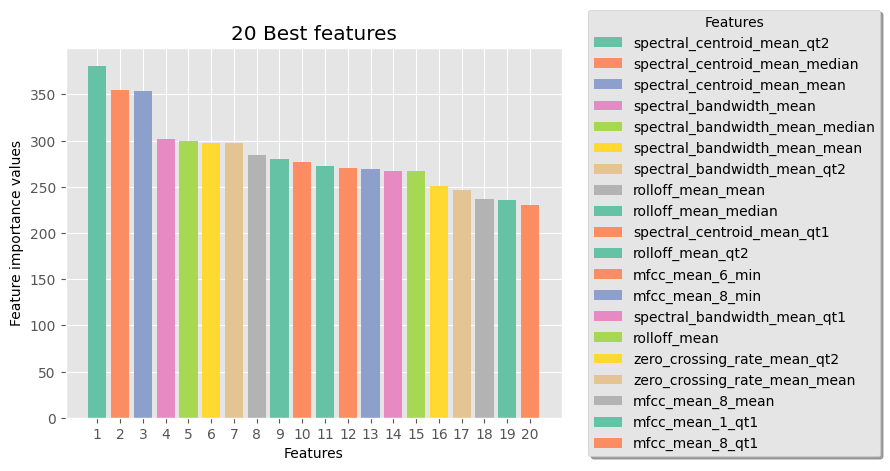

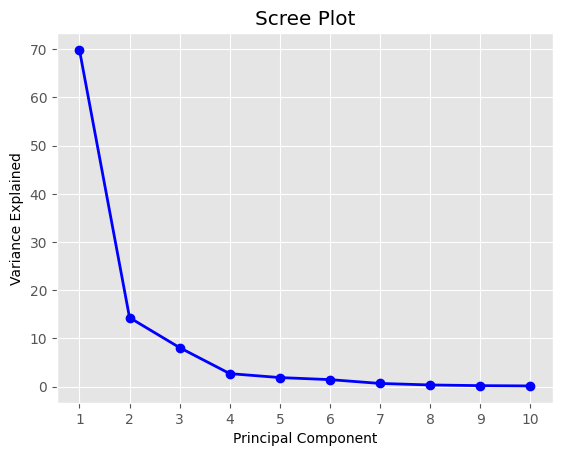

In [27]:
interpret_steps(pipeline=pipeline_pca, features= input_features)

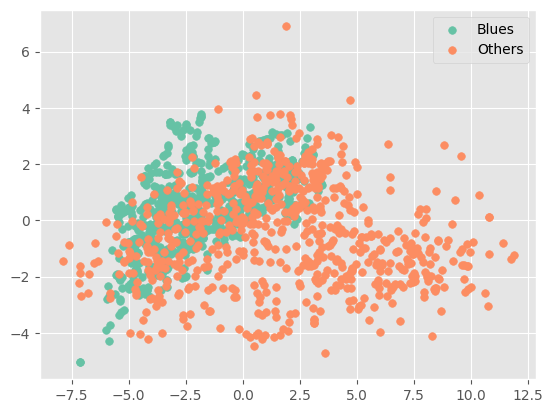

In [28]:
ax = plt.subplot()

for i in range(2):
    ax.scatter(
        X_train_pca.iloc[y_train == i, 0],
        X_train_pca.iloc[y_train == i, 1],
        c = f"C{i}",
        label = le.inverse_transform([i]).item().capitalize(),
        s = 30)

plt.legend(loc = "best")

plt.show()

In [29]:
# mdc_grid = GridSearchCV(
#     MDC(),
#     param_grid={"metric" : ['euclidean','mahalanobis']},
#     scoring="f1",
#     n_jobs=4,
#     verbose=2,
#     cv = 5
# )

# mdc_grid.fit(X_train,y_train)

In [30]:
# mdc_grid.best_params_

In [31]:
rf_grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid={"n_estimators": np.arange(10,101,5)},
    scoring="f1",
    n_jobs=4,
    verbose=2,
    cv = 5
)

rf_grid.fit(X_train, y_train)


Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=10; total time=   0.1s
[CV] END ....................................n_estimators=15; total time=   0.2s
[CV] END ....................................n_estimators=15; total time=   0.2s
[CV] END ....................................n_estimators=15; total time=   0.2s
[CV] END ....................................n_estimators=15; total time=   0.2s
[CV] END ....................................n_estimators=15; total time=   0.2s
[CV] END ....................................n_estimators=20; total time=   0.2s
[CV] END ....................................n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100])},
             scoring='f1', verbose=2)

In [32]:
lda_crossval_scores = cross_val_score(
    LDA(), 
    X_train, y_train,
    cv = 50,
    scoring="f1", n_jobs = 8)

mdc_crossval_scores = cross_val_score(
    MDC(),
    X_train,y_train,
    cv = 50,
    scoring="f1",
    n_jobs=8
)

rf_crossval_scores = cross_val_score(
    RandomForestClassifier(**rf_grid.best_params_),
    X_train, y_train,
    cv=50,
    scoring="f1",
    n_jobs=8
)

cross_dict = {
    "Fisher's LDA" : lda_crossval_scores,
    "MDC": mdc_crossval_scores,
    "Random Forest" : rf_crossval_scores
}

cross_val_scores = pd.DataFrame(cross_dict)

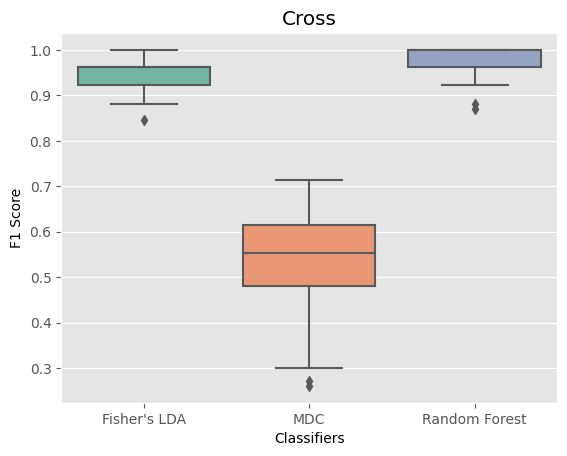

In [33]:
ax = plt.subplot()
sns.boxplot(cross_val_scores, ax = ax)

ax.set(
    title = "Cross",
    xlabel = "Classifiers",
    ylabel = "F1 Score"
)
plt.show()

In [34]:
mdc = MDC()
lda = LDA()
rf = RandomForestClassifier(**rf_grid.best_params_)

In [35]:
mdc.fit(X_train, y_train)
lda.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=80)

In [36]:
mdc_y_pred = mdc.predict(X_test)
lda_y_pred = lda.predict(X_test)
rf_y_pred = rf.predict(X_test)

<Axes: >

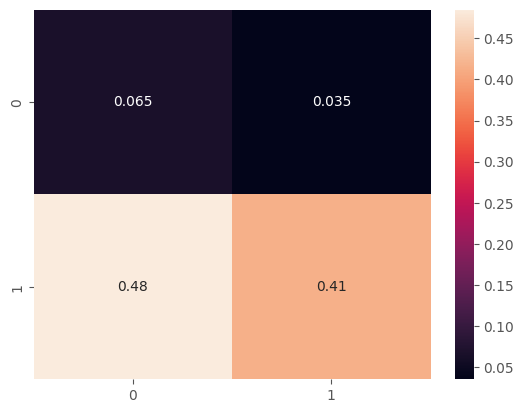

In [37]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = mdc_y_pred, normalize = "all")
sns.heatmap(conf_matrix, annot=True)

<Axes: >

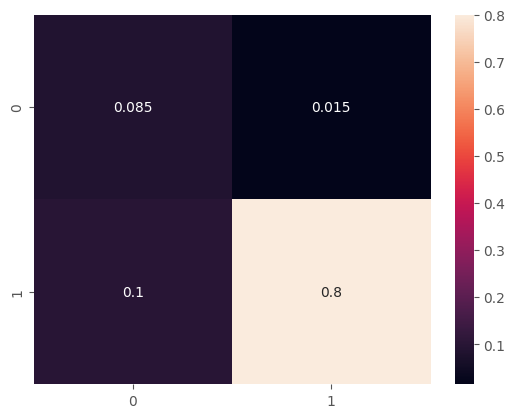

In [38]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = lda_y_pred, normalize = "all")
sns.heatmap(conf_matrix, annot=True)

<Axes: >

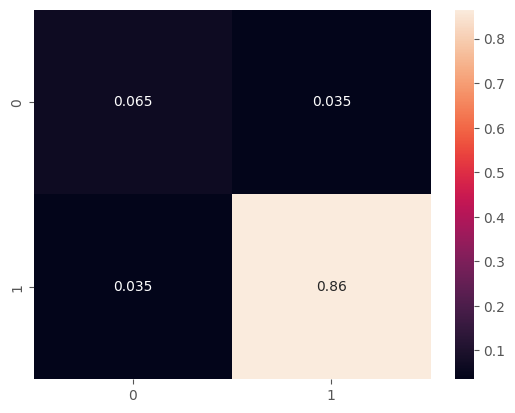

In [39]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = rf_y_pred, normalize = "all")
sns.heatmap(conf_matrix, annot=True)

In [40]:
(
    mdc.score(X_test, y_test),
    lda.score(X_test, y_test),
    rf.score(X_test,y_test)
)

(0.48, 0.885, 0.93)

In [41]:
(
    recall_score(y_true = y_test, y_pred = mdc_y_pred),
    recall_score(y_true = y_test, y_pred = lda_y_pred),
    recall_score(y_true = y_test, y_pred = rf_y_pred)
)

(0.46111111111111114, 0.8888888888888888, 0.9611111111111111)

In [42]:
(
    precision_score(y_true=y_test, y_pred=mdc_y_pred),
    precision_score(y_true=y_test, y_pred=lda_y_pred),
    precision_score(y_true=y_test, y_pred=rf_y_pred),
)

(0.9222222222222223, 0.9815950920245399, 0.9611111111111111)

In [43]:
(
    f1_score(y_true = y_test, y_pred = mdc_y_pred),
    f1_score(y_true = y_test, y_pred = lda_y_pred),
    f1_score(y_true=y_test, y_pred = rf_y_pred)
)

(0.6148148148148149, 0.932944606413994, 0.9611111111111111)

In [44]:
(
    matthews_corrcoef(y_true=y_test, y_pred=mdc_y_pred),
    matthews_corrcoef(y_true=y_test, y_pred=lda_y_pred),
    matthews_corrcoef(y_true=y_test, y_pred=rf_y_pred)
)

(0.0670025210172808, 0.5708680298329899, 0.6111111111111112)